# Ensemble Learning

**Ensemble learning** is usually really powerful for classification problems and tends to perform better than its singular components.

## Learning with ensembles

What we are going to do is to combine different classifiers into a meta classifier that performs better than anyone of its components. Here we will focus on **majority voting** meaning that we will select the class that has been chosen by the absolute majority of classifiers.

While majority voting refers to binary classifiers, we can extend the method to multiclass problems with **plurality voting** which is going to select the label based on simple majority (mode).

Ensemble methods work better than simple classifiers because we *combine* the classifications from every one of them making errors more unlikely. We can use combinatorics to show how it works:

$$
P(y \geq k)=\sum_{k}^{n}{n \choose k}\varepsilon^{k}(1-\varepsilon)^{n-k}=\varepsilon_{ensemble}
$$

${n \choose k}$ is the binomial coefficient *n choose k*, so what we basically do is compute the probability that the prediction of the ensemble is wrong. Below an example with 11 base classifiers ($n=11$) with an error rate of 0.25 ($\varepsilon=0.25$):

$$
P(y \geq k)=\sum_{k=6}^{11}{11 \choose k}0.25^{k}(1-\varepsilon)^{11-k}=0.034
$$

As we can see the error rate of the ensemble is much lower than the error rate of any individual classifier. To compare an ensemble classifier to a base classifier let's implement the probability mass function in Python

In [1]:
from scipy.misc import comb
import math

In [2]:
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [3]:
ensemble_error(11, 0.25)

0.034327507019042969

Now we can visualize the relationship between ensemble and base errors from 0.0 to 1.0

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

In [5]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(11, error) for error in error_range]

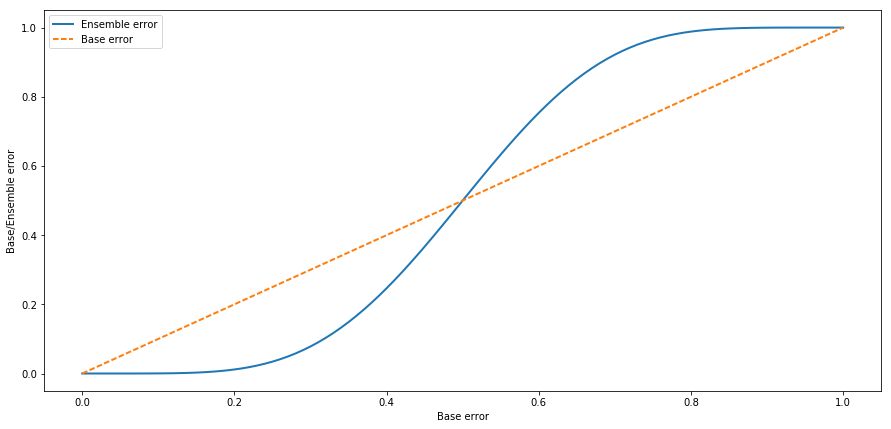

In [8]:
plt.plot(error_range, ens_errors,
         label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, 
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.show()

As we can see in the plot above the ensemble will always perform better than the base classifier as long as the error of the base classifier is better than random guessing (50-50).

## Implementing a majority voting classifier